In [5]:
import tensorflow as tf
from models import decoder, encoder, vae, classifier
import pandas as pd
import pathlib
from constants import *
from utils import data_loading
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [6]:
apes_info = pd.read_csv(APES_INFO_FILEPATH)
all_images_ids, train_ids, validation_ids, test_ids = data_loading.get_image_ids(apes_info, pathlib.Path(DATA_FILEPATH))

In [7]:
dataset = data_loading.load_full_dataset(DATA_FILEPATH, IMAGE_SIZE, all_images_ids)

y_train, y_validation, y_test, feature_value_names = data_loading.get_feature_dataset(apes_info, FEATURE_NAMES)

Found 10000 files belonging to 10000 classes.


In [8]:
decoder_model = decoder.build_decoder(LATENT_DIM)
encoder_model = encoder.build_encoder(LATENT_DIM)

vae_model = vae.VAE(encoder_model, decoder_model, RECONSTRUCTION_LOSS_WEIGHT, KL_LOSS_WEIGHT)
vae_model.load_weights(MODEL_VAE_FILEPATH)

classifier_model = classifier.build_classifier(encoder_model,
                                               [512, 1024, 1024],
                                               [0.15, 0.15, 0.15],
                                               N_UNIQUE_FEATURES, FEATURE_NAMES)
classifier_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=[tf.keras.losses.BinaryCrossentropy(from_logits=False)] * len(FEATURE_NAMES),
    metrics=["accuracy"],
)

In [9]:
x_train = data_loading.load_specific_dataset(dataset, train_ids, None)
train_dataset = tf.data.Dataset.zip((x_train, y_train)).batch(BATCH_SIZE)

x_validation = data_loading.load_specific_dataset(dataset, validation_ids, None)
validation_dataset = tf.data.Dataset.zip((x_validation, y_validation)).batch(BATCH_SIZE)

In [10]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_CLASSIFIER_FILEPATH,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

csv_logger = tf.keras.callbacks.CSVLogger(HISTORY_CLASSIFIER_FILEPATH, append=True)

In [19]:
history = classifier_model.fit(
    train_dataset.repeat(STEPS_PER_EPOCH * 10),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=10,
    batch_size=None,
    validation_data=validation_dataset,
    callbacks=[model_checkpoint, csv_logger],
)

Epoch 1/10


2023-05-25 09:37:15.056428: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype bool and shape [7000,33]
	 [[{{node Placeholder/_12}}]]
2023-05-25 09:37:15.056643: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_16' with dtype bool and shape [7000,37]
	 [[{{node Placeholder/_16}}]]


54/54 [==============================] - 45s 834ms/step - loss: 0.1783 - Mouth_loss: 0.0366 - Background_loss: 0.0045 - Hat_loss: 0.0155 - Eyes_loss: 0.0586 - Clothes_loss: 0.0150 - Fur_loss: 0.0480 - Mouth_accuracy: 0.7811 - Background_accuracy: 0.9961 - Hat_accuracy: 0.9252 - Eyes_accuracy: 0.7332 - Clothes_accuracy: 0.9112 - Fur_accuracy: 0.8236 - val_loss: 0.2657 - val_Mouth_loss: 0.0385 - val_Background_loss: 0.0130 - val_Hat_loss: 0.0163 - val_Eyes_loss: 0.0760 - val_Clothes_loss: 0.0166 - val_Fur_loss: 0.1053 - val_Mouth_accuracy: 0.7467 - val_Background_accuracy: 0.9920 - val_Hat_accuracy: 0.9020 - val_Eyes_accuracy: 0.6153 - val_Clothes_accuracy: 0.8793 - val_Fur_accuracy: 0.5593
Epoch 2/10
54/54 [==============================] - 45s 842ms/step - loss: 0.1754 - Mouth_loss: 0.0360 - Background_loss: 0.0044 - Hat_loss: 0.0157 - Eyes_loss: 0.0585 - Clothes_loss: 0.0143 - Fur_loss: 0.0465 - Mouth_accuracy: 0.7852 - Background_accuracy: 0.9962 - Hat_accuracy: 0.9255 - Eyes_accurac

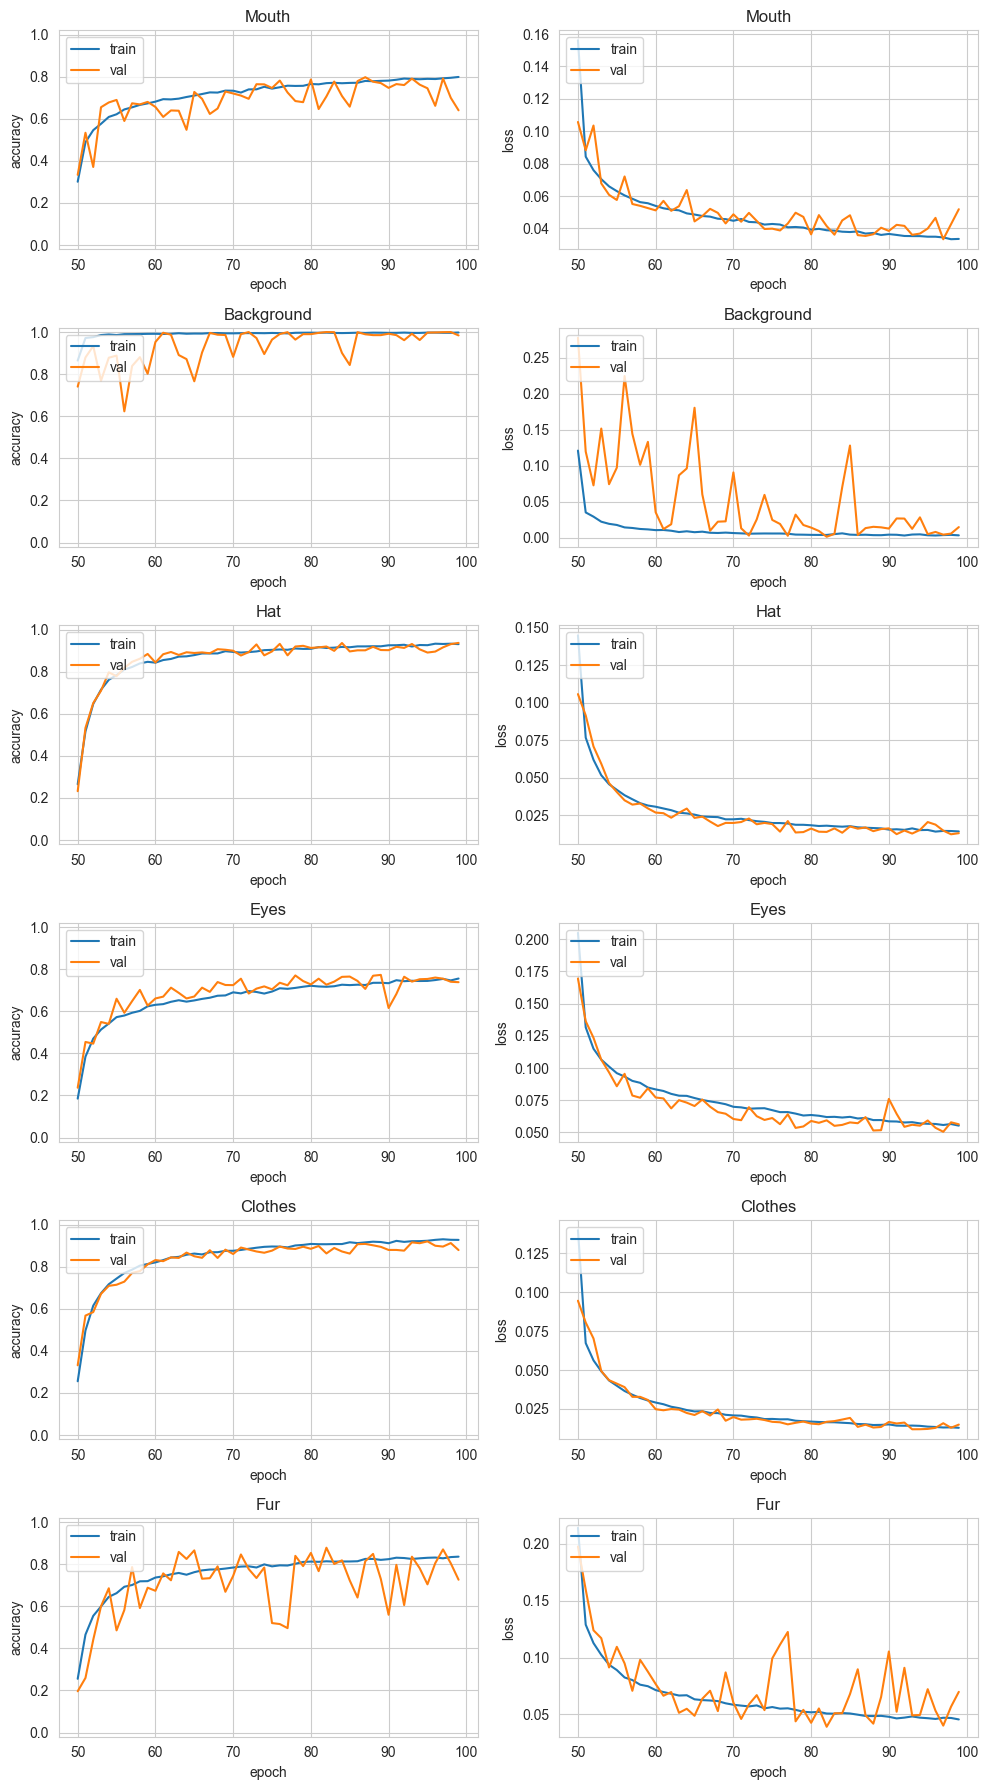

In [24]:
history_classifier_training = pd.read_csv(HISTORY_CLASSIFIER_FILEPATH).iloc[-50:]

plt.figure(figsize=(10, len(FEATURE_NAMES) * 3))

for i, feature_name in enumerate(FEATURE_NAMES):
    plt.subplot(len(FEATURE_NAMES), 2, i * 2 + 1)
    plt.plot(history_classifier_training[f"{feature_name}_accuracy"])
    plt.plot(history_classifier_training[f"val_{feature_name}_accuracy"])
    plt.title(feature_name)
    plt.ylim([-0.02, 1.02])
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")

    plt.subplot(len(FEATURE_NAMES), 2, i * 2 + 2)
    plt.plot(history_classifier_training[f"{feature_name}_loss"])
    plt.plot(history_classifier_training[f"val_{feature_name}_loss"])
    plt.title(feature_name)
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()

In [25]:
abc = classifier_model.predict(validation_dataset)

12/12 [==============================] - 15s 1s/step


In [26]:
classifier_model.summary()

Model: "classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 encoder (Functional)        [(None, 256),                2201184   ['input_3[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                                  
 concatenate (Concatenate)   (None, 768)                  0         ['encoder[0][0]',             
                                                                     'encoder[0][1]',    

In [27]:
a = list(y_validation)

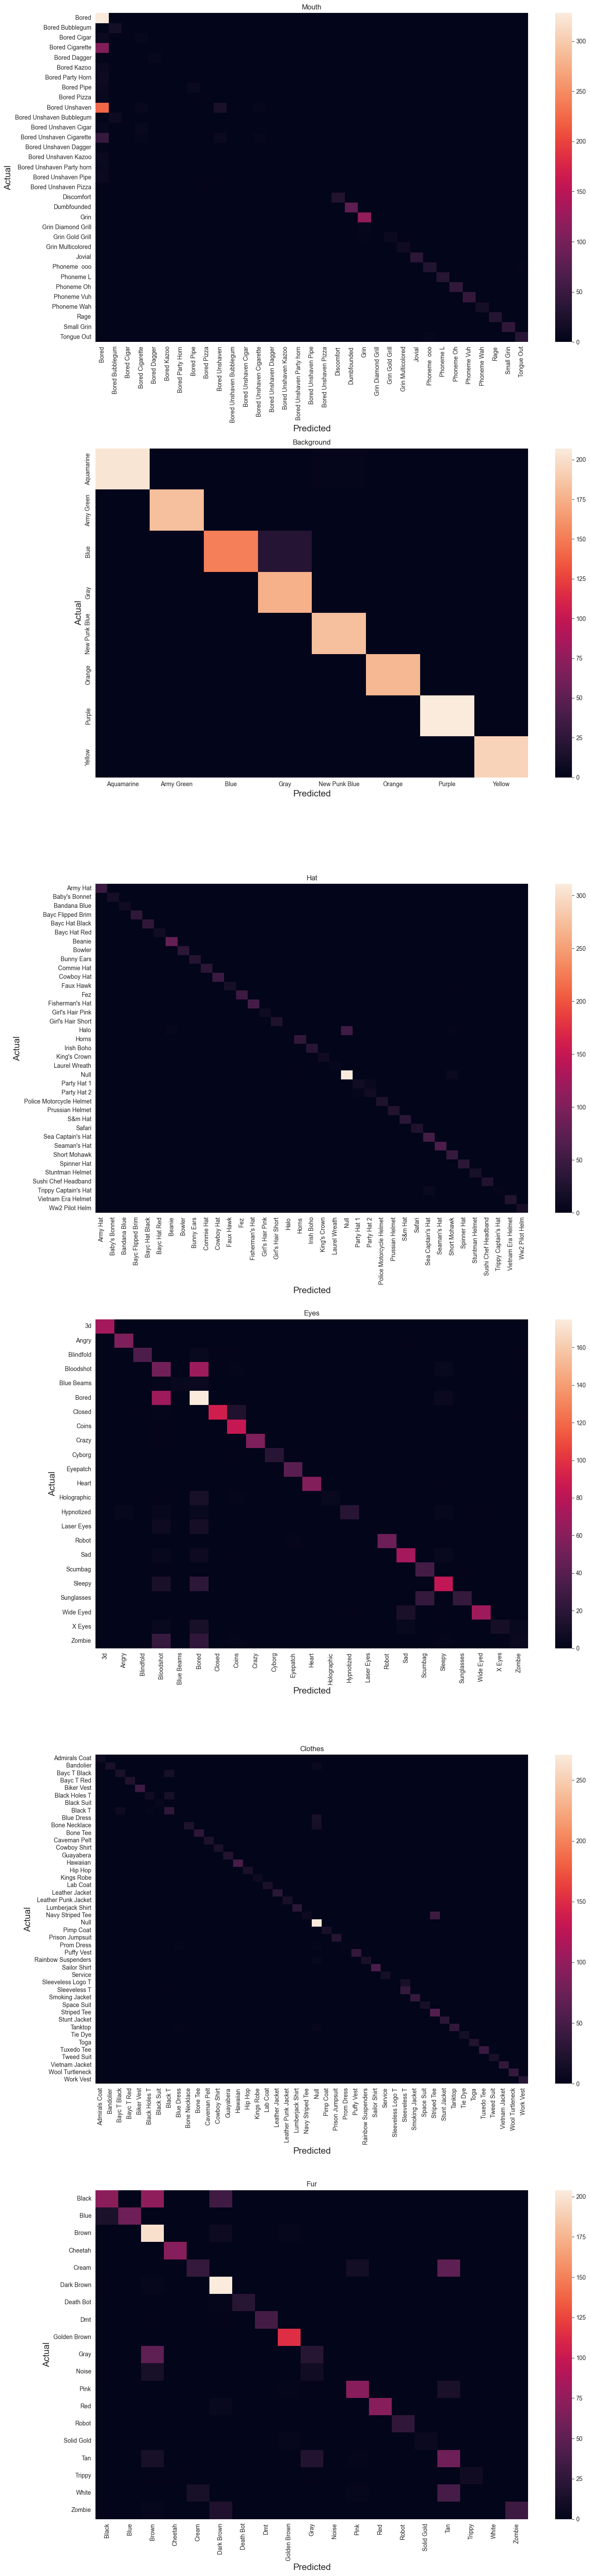

In [28]:
plt.figure(figsize=(15, len(FEATURE_NAMES) * 10))

for i, feature_name in enumerate(FEATURE_NAMES):
    cfm = confusion_matrix(np.argmax([x[i] for x in a], axis=1), np.argmax(abc[i], axis=1))
    df_cm = pd.DataFrame(cfm, index = feature_value_names[feature_name],
                  columns = feature_value_names[feature_name])

    plt.subplot(len(FEATURE_NAMES), 1, i + 1)
    sn.heatmap(df_cm)
    plt.title(feature_name)
    plt.xlabel('Predicted', fontsize = 15)
    plt.ylabel('Actual', fontsize = 15)

plt.tight_layout()
plt.show()